In [25]:
from keras.datasets import mnist
import numpy as np

In [26]:
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

In [27]:
x_train.shape

(60000, 28, 28, 1)

In [28]:
# 添加噪声
noise_factor = 0.5
# loc, scale, size 代表生成的高斯分布的随机数的均值、方差以及输出的size
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
# numpy.clip(a, min, max, out=None)[source]
# clip将将数组中的元素限制在min, max之间，大于max的就使得它等于 max，小于min的就使它等于a_min。
# 限制x_train加噪后像素值仍处于0至1之间
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

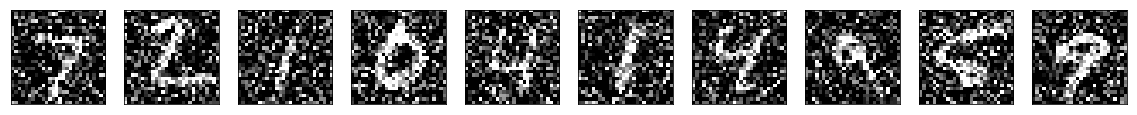

In [29]:
# 画出噪音图片
import matplotlib.pyplot as plt
%matplotlib inline

n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [30]:
from keras.layers import Input, Dense, Conv2D, MaxPool2D, UpSampling2D
from keras.models import Model, load_model

# encoder
input_img = Input(shape=(28, 28, 1,))
x = Conv2D(32, (3, 3), padding='same', activation='relu',)(input_img)
x = MaxPool2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
encoded = MaxPool2D((2, 2), padding='same')(x)  # 7*7*32

In [31]:
# decoder
x = Conv2D(32, (3, 3), padding='same', activation='relu')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), padding='same', activation='sigmoid')(x)  # 28*28*1

In [32]:
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [33]:
x_train_noisy.shape

(60000, 28, 28, 1)

In [34]:
autoencoder.fit(x_train_noisy, x_train, 
                epochs=100, 
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))
autoencoder.save('./data/autoencoder.h5')

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
20224/60000 [=========>....................] - ETA: 1:29 - loss: 0.2490

KeyboardInterrupt: 

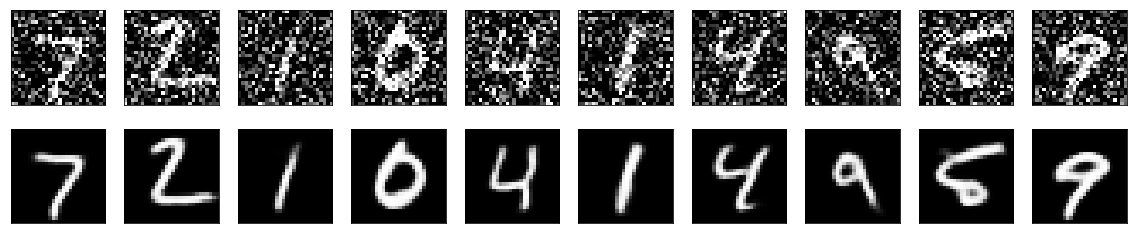

In [36]:
autoencoder = load_model('./data/autoencoder.h5')

decoded_imgs = autoencoder.predict(x_test_noisy)
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i + 1 +n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.savefig('./images/noise.png')
plt.show()
